<a href="https://colab.research.google.com/github/bhushan1729/Generative-AI-Algorithms/blob/main/Implementation_of_VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load all necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Vector Quantizer
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super(VectorQuantizer, self).__init__()
    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.commitment_cost = commitment_cost

    self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
    self.embeddings.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

  def forward(self, z):
    # z: [B, D, H, W] -> [BHW, D]
    z_perm = z.permute(0, 2, 3, 1).contiguous()
    flat_z = z_perm.view(-1, self.embedding_dim)

    # Distance to embeddings
    distance = (flat_z.pow(2).sum(1, keepdim=True)
                -2* flat_z @ self.embeddings.weight.t()
                + self.embeddings.weight.pow(2).sum(1))

    encoding_indices = torch.argmin(distance, dim=1)
    quantized = self.embeddings(encoding_indices).view(z_perm.shape)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()

    # Losses
    e_latent_loss = F.mse_loss(quantized.detach(), z)
    q_latent_loss = F.mse_loss(quantized, z.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # Straight-through estimator
    quantized = z + (quantized - z).detach()

    return quantized, loss

In [6]:
# VQ-VAE Model
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),             # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, embedding_dim, 4, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU()
        )

        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 32, 4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),             # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss = self.quantizer(z)
        x_hat = self.decoder(quantized)
        return x_hat, vq_loss

In [8]:
# Trainin setup
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

loss_curve = []
epochs = 15

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.87MB/s]


In [9]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [11]:
# Training loop
avg_loss = 0
avg_curve = []
for epoch in range(epochs):
  model.train()
  total_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    x_hat, vq_loss = model(x)
    recon_loss = F.mse_loss(x_hat, x)
    loss = recon_loss + vq_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  avg_curve.append(total_loss / len(train_loader))
  loss_curve.append(avg_loss)
  print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000


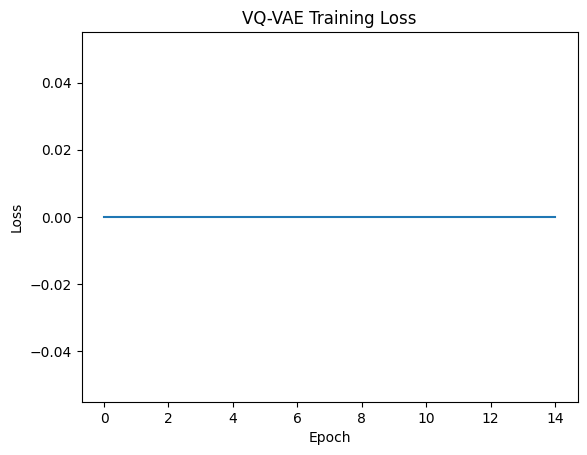

In [12]:
# Plot loss curve
plt.plot(loss_curve)
plt.title('VQ-VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

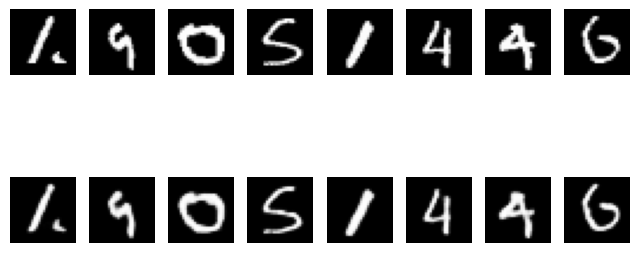

<Figure size 640x480 with 0 Axes>

In [13]:
# Reconstruction
model.eval()
with torch.no_grad():
  for x, _ in train_loader:
    x = x.to(device)
    x_hat, _ = model(x)
    x = x.cpu().numpy()
    x_hat = x_hat.cpu().numpy()
    break

plt.figure(figsize=(8, 4))
for i in range(8):
  plt.subplot(2, 8, i+1)
  plt.imshow(x[i][0], cmap='gray')
  plt.axis('off')
  plt.subplot(2, 8, i+9)
  plt.imshow(x_hat[i][0], cmap='gray')
  plt.axis('off')
plt.show()

plt.suptitle('Top: Original | Bottom: Reconstruction')
plt.tight_layout()
plt.show()

In [14]:
# Fit a GMM on latents to be able to sample
# obtain all the latents

all_latents = []
model.eval()
with torch.no_grad():
  for x, _ in train_loader:
    x = x.to(device)
    z_e = model.encoder(x)           # [B, D, H, W]
    z_e = z_e.permute(0, 2, 3, 1).contiguous().view(-1, model.quantizer.embedding_dim)
    all_latents.append(z_e.cpu())

all_latents = torch.cat(all_latents, dim=0).numpy()

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=20, covariance_type = 'full', random_state=0)
gmm.fit(all_latents)

KeyboardInterrupt: 

In [16]:
samples = gmm.sample(n_samples=16 * 7 * 7)[0]  # for 16 images of 7x7 codes
samples = torch.tensor(samples, dtype=torch.float32).view(16, 7, 7, -1).to(device)

In [17]:
# Flatten and compute nearest codebook vectors
flat = samples.view(-1, samples.shape[-1])
dist = (flat.pow(2).sum(1, keepdim=True)
        -2 * flat @ model.quantizer.embeddings.weight.t()
        + model.quantizer.embeddings.weight.pow(2).sum(1))
encoding_indices = torch.argmin(dist, dim=1)

# Get quantized vectors
quantized = model.quantizer.embeddings(encoding_indices)
quantized = quantized.view(16, 7, 7, -1).permute(0, 3, 1, 2).contiguous()

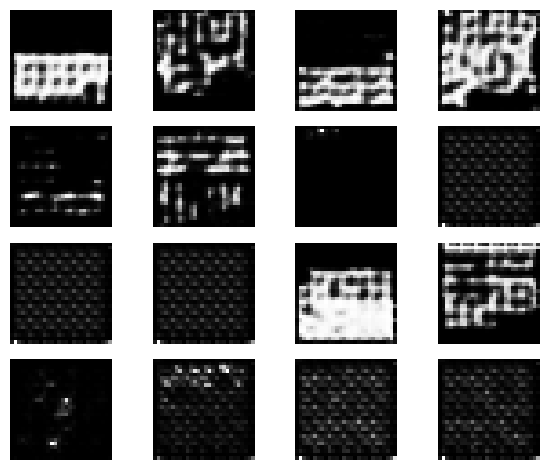

In [18]:
with torch.no_grad():
  generated = model.decoder(quantized)

# Plot the results
import matplotlib.pyplot as plt
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(generated[i][0].cpu().numpy(), cmap='gray')
  plt.axis('off')
  plt.tight_layout()
plt.show()

In [ ]:
# GMM model is not fully train and therefore quantized vectors are not very clear